# Ablations Transformer Model Training Notebook

In this notebook, we created and trained a transformer model based on our ablation experiment setup. The architecture is defined as per the 'experiment_model.py' file, and we utilise functions created in the 'base_functions.py' file to facilitate the training process. The main aim of this notebook is to perform sanity checks on our model implementation and training loop, as well as to establish a baseline performance for future model improvements to be compared against.

In [1]:
import matplotlib.pyplot as plt
import optax
import sys
import jax
import time
import os
import numpy as np
from pathlib import Path

cwd = Path.cwd()

# Project root for local setup
project_root = cwd.parents[1]
sys.path.append(str(project_root)) # sets the project root directory to be two levels up from the current working directory

from ablations.experiment_setup import experiment_utils as fn 

# Load the Experiment Setup

## Set the relevant directory paths & update.log file

In [2]:
# Data directory paths
local_dir = project_root / "data" / "text8_train.txt"
online_dir = project_root / "text8_train.txt"

if local_dir.exists():
    data_dir = str(local_dir) # This is for local runs or if repository is cloned directly
else:
    data_dir = str(online_dir) # This is for online GPU platforms
    
config_path = cwd / "config.json"
training_log_file = cwd / "training_results.log"
validation_log_file = cwd / "validation_results.log"
checkpoint_file = cwd / "checkpoint.pkl"

In [3]:
if not os.path.exists(training_log_file):
    fn.initialize_training_log(training_log_file)

if not os.path.exists(validation_log_file):
    fn.initialize_validation_log(validation_log_file)

[initialize_training_log] Initialized training log file at /Users/robbs/Documents/NUS/AY25_26/Year4Sem1/DSA4212/character_LLM/ablations/experiment_setup/training_results.log
[initialize_validation_log] Initialized validation log file at /Users/robbs/Documents/NUS/AY25_26/Year4Sem1/DSA4212/character_LLM/ablations/experiment_setup/validation_results.log


## Load the experiment configurations

In [4]:
config = fn.load_config("./sample_config.json")

print(f"We will be conducting {config['description']}.")

[load_config] Loaded configuration from ./sample_config.json
We will be conducting Ablation test for loss function applied at every position, with auxiliary loss.


In [5]:
# Load the seed
seed = config['seed']

# Model parameters
vocab_size = config['model']['vocab_size']
d_model = config['model']['d_model']
n_heads = config['model']['n_heads']
n_layers = config['model']['n_layers']
mlp_ratio = config['model']['mlp_ratio']
seq_len = config['model']['seq_len']

# Training parameters
loss_type = config['model']['loss_type']
dropout_rate = config['model']['dropout']
weight_decay = config['model']['weight_decay']
label_smoothing = config['model']['label_smoothing']

# Mixed precision and other model settings
use_mixed_precision = config['model']['mixed_precision']
pos_encoding = config['model']['pos_encoding']
attention_type = config['model']['attention_type']

# Auxiliary loss settings
use_auxiliary_loss = config['model']['use_auxiliary_loss']
aux_heads = config['model']['aux_heads']
aux_weight = config['model']['aux_weight']

In [6]:
# Throughput test parameters
max_test_iters = config['throughput']['max_test_iters']
max_test_time_in_seconds = config['throughput']['max_test_time_in_seconds']
compute_budget_hours = config['throughput']['compute_budget_hours']

# Training settings
val_fraction = config['training']['val_fraction']
batch_size = config['training']['batch_size']
learning_rate = config['training']['learning_rate']
lr_schedule = config['training']['lr_schedule']
optimizer_type = config['training']['optimizer']

# Loading the Data

The dataset used is the text8 dataset, which has 100M characters of text data from Wikipedia articles. It contains only lowercase letters and spaces, and is already pre-split into 90M characters for training and 10M characters for testing.

In [7]:
# Read in training text file
with open(data_dir, 'r', encoding='utf-8') as f:
    train_text = f.read()
print(f"Training text loaded. Length: {len(train_text) :,} characters.")

# Inspect first 500 characters of training text
print("First 500 characters of training text:")
print(train_text[:500])

Training text loaded. Length: 90,000,000 characters.
First 500 characters of training text:
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


In [8]:
chars = sorted(set(train_text)) # unique characters in training text
chars_to_int = {ch: i for i, ch in enumerate(chars)} # char to int mapping
int_to_chars = {i: ch for i, ch in enumerate(chars)} # int to char mapping

print(f"Unique characters in training text: {len(chars)}") # should be 27, including space (sanity check)

Unique characters in training text: 27


We further split the training data into a training set and a validation set to monitor the model's performance during training, in accordance to the validation fraction specified in our configuration file (10%)

In [9]:
train_text, val_text = fn.split_train_val(train_text, val_fraction=val_fraction)

print(f"Training text length: {len(train_text) :,} characters.")
print(f"Validation text length: {len(val_text) :,} characters.")

Training text length: 89,099,996 characters.
Validation text length: 900,004 characters.


# Model Initialisation

## Model Setup

We intialise our model with the following parameters in accordance to our configuration file:
Based on these parameters, our model has approximately ~3.2M parameters.

In [10]:
# Define the model params
rng = jax.random.PRNGKey(seed)

model_obj, params, constants = fn.create_train_state(
        rng,
        vocab_size = vocab_size,
        d_model = d_model,
        n_heads = n_heads,
        n_layers = n_layers,
        mlp_ratio = mlp_ratio,
        seq_len = seq_len,
        dropout = dropout_rate,
        aux_loss = use_auxiliary_loss,
        num_aux_heads = aux_heads,
        mixed_precision = use_mixed_precision,
        attention_type = attention_type,
        pos_encoding = pos_encoding
)

In [11]:
total_params = fn.count_parameters(params)

print(f"Total number of parameters in the model: {total_params :,}")

Total number of parameters in the model: 3,188,224


We perform a sanity check by running a single forward pass with random input data to ensure the model is functioning as expected.

In [12]:
# SANITY CHECK: Test the model forward pass
B, T = 2, 8  # Batch size and sequence length
batch = jax.random.randint(key = rng, shape = (B, T), minval = 0, maxval = vocab_size)

variables = {"params": params, "constants": constants}
output = model_obj.apply(variables, batch, deterministic=False)
print("Logits shape:", output["logits"].shape)  # Expected: (B, T, vocab_size)

Logits shape: (2, 8, 27)


## Initialise the optimizer

We use the Adam optimizer with a learning rate of 1e-3 for training our model.

In [13]:
# Define the learning rate
learning_rate = 1e-3

# Create the Optimizer and initialize it
if optimizer_type == "adam":
    optimizer = optax.adam(learning_rate)
elif optimizer_type == "sgd":
    optimizer = optax.sgd(learning_rate)
elif optimizer_type == "adamw":
    optimizer = optax.adamw(
        learning_rate = learning_rate,
        weight_decay = weight_decay
    )
    
opt_state = optimizer.init(params)

print("Optimizer initialized:", optimizer_type, "with Learning Rate =", learning_rate)

Optimizer initialized: adam with Learning Rate = 0.001


## Text encoding

We then encode the text data into integer format for model training. Each unique character is mapped to a unique integer index.

In [14]:
# Encode the train, val, test texts
train_data = fn.encode(train_text, chars_to_int)
val_data = fn.encode(val_text, chars_to_int)

## Determine maximum permissible training steps

Taking into account possible compute limitations, we perform a preliminary calculation to determine the maximum number of training steps we can perform based on the throughput of our model and the total training time available. For this preliminary test, we set a maximum training time of 60 seconds and a maximum of 1000 training steps.

We set our maximum compute budget for this baseline model to be 1 compute hour. Based on the throughput calculated from the preliminary test, the estimated maximum no. of training steps we can perform within this compute budget is ~180,000. As a benchmark, we set the maximum training steps to be 100,000.

In [15]:
# Determining how many steps we can run in a reasonable time
max_iters = max_test_iters 
max_time = max_test_time_in_seconds # in seconds
max_compute_time = compute_budget_hours # in hours

_ , max_steps = fn.calculate_throughput(
    max_test_iters = max_iters,
    max_test_time = max_time,
    model = model_obj,
    params = params,
    opt_state = opt_state,
    optimizer = optimizer,
    rng = rng,
    batch_size = 32,
    seq_len = seq_len,
    compute_budget = max_compute_time,
    train_data = train_data,
    loss_type = loss_type,
    aux_loss = use_auxiliary_loss,
    aux_weight = aux_weight,
    constants = constants
)

Stopping benchmark at iteration 83 due to time limit.
Benchmark completed in 60.73 seconds.
Total tokens processed: 344064
Throughput: 5665.65 tokens/second
Estimated max steps within compute budget: 9959.0


# Model Training & Evaluation

## Training the model

Now, we proceed to train the model over the determined number of training iterations. During training, we monitor the training loss and periodically evaluate the model on the validation set to track its performance. We also make sure to record the time taken for training to ensure it stays within our compute budget.

In [16]:
iter_max = 60

# To track training and validation loss, as well as time taken
train_loss_history = []
val_loss_history = []
train_time_history = []
val_time_history = []

# Load checkpoint if it exists
params, opt_state, constants, start_iter = fn.load_checkpoint(
    checkpoint_file,
    params,
    constants,
    opt_state
)

[load_checkpoint] No checkpoint found at /Users/robbs/Documents/NUS/AY25_26/Year4Sem1/DSA4212/character_LLM/ablations/experiment_setup/checkpoint.pkl
[load_checkpoint] Starting training as per usual.


In [17]:
if start_iter > 0:
        print(f"Resuming training from iteration = {start_iter}.")
else:
        print("Starting training from iteration = 0.")

time_start = time.time()

for it in range(start_iter, iter_max):

    # get a batch of data
    inputs, targets = fn.get_batch(train_data, batch_size, seq_len)

    # Perform a training step
    rng, sub = jax.random.split(rng)
    new_params, new_opt_state, metrics = fn.train_step(
            model = model_obj, 
            params = params, 
            constants=constants,
            opt_state = opt_state, 
            x = inputs, 
            y = targets, 
            tx = optimizer,
            rng = sub, 
            loss_type = loss_type, 
            aux_loss = use_auxiliary_loss, 
            aux_weight = aux_weight
    )

    # Update parameters and optimizer state
    params = new_params
    opt_state = new_opt_state

    # Record training metrics
    acc = metrics['acc']
    loss = metrics['loss']
    last_char_acc = metrics['acc_last']
    train_time = time.time() - time_start

    train_loss_history.append(loss)
    train_time_history.append(train_time)

    fn.update_training_log(
        log_path = "training_results.log",
        step = it,
        train_loss = loss,
        train_time = train_time,
        train_acc = acc,
        last_char_acc = last_char_acc
        )

    if it % (iter_max // 50) == 0 or it == iter_max - 1: # Print every 2% of iterations

        # Compute the loss on validation set
        batch_size_val = batch_size
        seq_len_val = seq_len
        val_inputs, val_targets = fn.get_batch(val_data, batch_size_val, seq_len_val)

        val_out = model_obj.apply({"params": params, "constants": constants}, val_inputs, deterministic=True)
        val_logits = val_out["logits"]
        val_aux_logits = val_out.get('aux_logits', None)

        val_loss, val_metrics = fn.loss_and_metrics(
              logits = val_logits, 
              targets = val_targets, 
              loss_type = loss_type, 
              aux_loss = use_auxiliary_loss, 
              aux_logits = val_aux_logits,
              aux_weight = aux_weight
        )

        # Record validation loss and time
        val_acc = val_metrics['acc']
        last_char_acc_val = val_metrics['acc_last']
        val_loss_history.append(val_loss)
        time_elapsed = time.time() - time_start
        val_time_history.append(time_elapsed)

        fn.update_validation_log(
            log_path = "validation_results.log",
            step = it,
            val_loss = val_loss,
            val_time = time_elapsed,
            val_acc = val_acc,
            last_char_val_acc = last_char_acc_val
        )

        fn.save_checkpoint(
            checkpoint_path = checkpoint_file,
            params = params,
            constants = constants,
            opt_state = opt_state,
            step = it,
            time_elapsed = time_elapsed
        )

        # Print training and validation metrics
        print(f"Iteration {it}, time elapsed: {time_elapsed:.2f} seconds")
        print(f"\t \t Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"\t \t Training Acc: {acc:.4f}, Validation Acc: {val_acc:.4f}")
        print(f"\t \t Last Char Training Acc: {last_char_acc:.4f}, Last Char Validation Acc: {last_char_acc_val:.4f}")
        print("-" * 50)

print(f"Training completed in {time.time() - time_start:.2f} seconds.")

Starting training from iteration = 0.
[save_checkpoint] Saved checkpoint at step 0 to /Users/robbs/Documents/NUS/AY25_26/Year4Sem1/DSA4212/character_LLM/ablations/experiment_setup/checkpoint.pkl
Iteration 0, time elapsed: 13.15 seconds
	 	 Training Loss: 5.2084, Validation Loss: 5.6818
	 	 Training Acc: 0.0442, Validation Acc: 0.0608
	 	 Last Char Training Acc: 0.0000, Last Char Validation Acc: 0.0938
--------------------------------------------------
[save_checkpoint] Saved checkpoint at step 1 to /Users/robbs/Documents/NUS/AY25_26/Year4Sem1/DSA4212/character_LLM/ablations/experiment_setup/checkpoint.pkl
Iteration 1, time elapsed: 14.12 seconds
	 	 Training Loss: 5.7026, Validation Loss: 5.1204
	 	 Training Acc: 0.0583, Validation Acc: 0.0740
	 	 Last Char Training Acc: 0.0312, Last Char Validation Acc: 0.1250
--------------------------------------------------
[save_checkpoint] Saved checkpoint at step 2 to /Users/robbs/Documents/NUS/AY25_26/Year4Sem1/DSA4212/character_LLM/ablations/e

## Plot the training and validation loss curves

After training, we plot the training and validation loss curves to visualize the model's learning progress over time. This helps us identify any potential issues such as overfitting or underfitting. We observe that the training loss decreases steadily, indicating that the model is learning effectively. The validation loss also shows a decreasing trend, suggesting that the model generalizes well to unseen data.

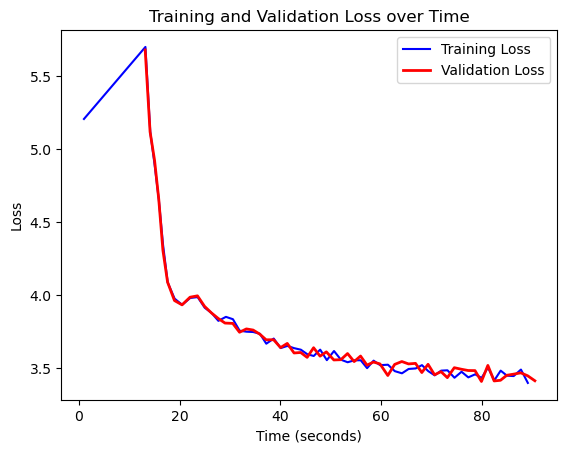

In [18]:
# Plot training and validation loss curves
plt.plot(train_time_history, train_loss_history, "-",label='Training Loss', color='blue')
plt.plot(val_time_history, val_loss_history, "-", label='Validation Loss', lw = 2, color='red')
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss over Time")
plt.legend()
plt.savefig(cwd / "loss_curve.png")
plt.show()

## Testing the model on a given prompt

We finally test the trained model by generating text based on a given prompt. The model successfully generates a sequence of characters that continue from the prompt.

In [ ]:
# Test the model on a given prompt
prompt = "the meaning of life is"
encoded_prompt = fn.encode(prompt, chars_to_int)
context = encoded_prompt[None, :]

B = 1
seed = seed
generate_len = 1000
rng = jax.random.PRNGKey(seed)

output_indices = fn.generate_tokens(
    model=model_obj,
    params=params,
    constants=constants,
    rng=rng,
    context=context,
    length=generate_len,
    block_size=64,
    temperature=0.8,
    sample=True,
    pad_id=None,
    deterministic=True
)

output_indices = np.array(output_indices)  # Convert from JAX array to NumPy array
generated_text = fn.decode(output_indices, int_to_chars)

print("Generated ID Shape:", output_indices.shape)
print("Generated Text:")
print(prompt + generated_text)

generated_text_file = cwd / "generated_text.txt"

with open(generated_text_file, "w") as f:
    f.write(prompt + generated_text)

Generated ID Shape: (1, 1000)
Generated Text:
the meaning of life isitolasriten cerang alr teroondetilas g itideveirondiner dy thesive icpang thouwee hod he t the heote cme me tithasongsterend wor th nefive hican  n llor te igo of thithedilthe halind the efererivedinc in aar liopr be imaf on pavarile thug cale te be ceilererefincwhalios tassth on bed cthaner ontrua s anin l a ofklo t saanco the thitis thidt or bonic itoryt or r ila ererata masit des t h al tor r dy beer be of a cere f wila f thererof t athe on the int tbex te thofthe wbisedelind as me achepor jonderisof themofxif me onghetesel pianias al wureinonesint alomastshe dan orondins mat ter ty an ph tipath seputathinest reridell tim esity dec hen aman beddetemeteris ssithe erg tixom alans oned tein inglthery e ox pitituss s min o migher omas fs thendialothandis tsomalour cenie theree alibis d thispoulin ts nd tinethene fthe s fy asubepetrinos ide hve sthomore se con iars he dike tof zerery thofie sthemelonenthed se omo the as 